To run this notebook, start Jupyter as follows from the Django project root: <br>
(https://medium.com/ayuth/how-to-use-django-in-jupyter-notebook-561ea2401852)

`python manage.py shell_plus --notebook`

<br>
NOTE:  You will need to changed the kernel from menu: `Kernel` > `Change kernel` > `Django Shell-Plus`

In [2]:
import os
import logging
import pandas as pd
import geopandas as gpd
import datetime

# for census data used in Bubble maps
from census import Census

# import variables in the local .env file
from dotenv import load_dotenv
load_dotenv(verbose=False)

True

In [3]:
# avoid chained assignment warnings
pd.options.mode.chained_assignment = None

# show all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
!pwd

/Users/markmcdonald/Desktop/marks-covid-tracker/tracker/notebooks


In [5]:
# GLOBAL VARIABLES
FILE_PATH = os.path.join('..', 'covid_tracker', 'COVID-19', 'csse_covid_19_data', 'csse_covid_19_time_series')

territories = ['American Samoa', 'Guam', 'Northern Mariana Islands', 'Mariana Islands',
               'Puerto Rico', 'Virgin Islands', 'Diamond Princess', 'Grand Princess']

# affiliation of governor in 2019
political_affiliations = {'American Samoa': 'na',
                          'Guam': 'na',
                          'Northern Mariana Islands': 'na',
                          'Puerto Rico': 'na',
                          'Virgin Islands': 'na',
                          'Alabama': 'red',
                          'Alaska': 'red',
                          'Arizona': 'red',
                          'Arkansas': 'red',
                          'California': 'blue',
                          'Colorado': 'blue',
                          'Connecticut': 'blue',
                          'Delaware': 'blue',
                          'District of Columbia': 'blue',
                          'Florida': 'red',
                          'Georgia': 'red',
                          'Hawaii': 'blue',
                          'Idaho': 'red',
                          'Illinois': 'blue',
                          'Indiana': 'red',
                          'Iowa': 'red',
                          'Kansas': 'blue',
                          'Kentucky': 'blue',
                          'Louisiana': 'blue',
                          'Maine': 'blue',
                          'Maryland': 'red',
                          'Massachusetts': 'red',
                          'Michigan': 'blue',
                          'Minnesota': 'blue',
                          'Mississippi': 'red',
                          'Missouri': 'red',
                          'Montana': 'blue',
                          'Nebraska': 'red',
                          'Nevada': 'blue',
                          'New Hampshire': 'red',
                          'New Jersey': 'blue',
                          'New Mexico': 'blue',
                          'New York': 'blue',
                          'North Carolina': 'blue',
                          'North Dakota': 'red',
                          'Ohio': 'red',
                          'Oklahoma': 'red',
                          'Oregon': 'blue',
                          'Pennsylvania': 'blue',
                          'Rhode Island': 'blue',
                          'South Carolina': 'red',
                          'South Dakota': 'red',
                          'Tennessee': 'red',
                          'Texas': 'red',
                          'Utah': 'red',
                          'Vermont': 'red',
                          'Virginia': 'blue',
                          'Washington': 'blue',
                          'West Virginia': 'red',
                          'Wisconsin': 'blue',
                          'Wyoming': 'red',
                          'Diamond Princess': 'na',
                          'Grand Princess': 'na'}

In [6]:
try:
    from django.http import JsonResponse

except Exception as e:
    print("NOT LOADED:  start notebook with:\n")
    print("\tpython manage.py shell_plus --notebook")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [7]:
!pwd

/Users/markmcdonald/Desktop/marks-covid-tracker/tracker/notebooks


In [8]:
import git
import json
from django.http import JsonResponse

def refresh_git(request):
    """
    Triggers a pull of the Git repository that hold the data used in plots.

    :param request: The HTML request which is provided by Django when the route is called.  No values of the request are used in this function.

    :return: A Json formatted text response that includes the git activity of the request to pull data.
    """
    try:
        g = git.cmd.Git('../covid_tracker/COVID-19')
        rv = g.pull()
    except Exception as e:
        rv = "Git sync in process..."

    print(rv)
#     return JsonResponse(json.dumps(rv), safe=False)

In [9]:
refresh_git(None)

Git sync in process...


In [10]:
# Get vaccination data
# Dataset web page
# https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh

# Download CSV Link
# https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD
# https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD&api_foundry=true

In [11]:
## NEXT: 
## Save data into CSV file
## Preload from CSV file before using API to get data

In [12]:
FILE_PATH_VAXDATA = os.path.join('..', 'covid_tracker', 'data', 'vaccinations')
os.path.isdir(FILE_PATH_VAXDATA)

True

In [17]:
import warnings
warnings.filterwarnings("ignore")

from sodapy import Socrata
from us import states

DATA_PATH = os.path.join('..', 'covid_tracker', 'data')
FILE_PATH_VAXDATA = os.path.join(DATA_PATH, 'vaccinations')

class Vax_Data:
    _json_cache: {} = {} # holds raw JSON data by date for reuse - avoids re-downloading for one data type
    _base_date: datetime.date = datetime.date(year=2020, month=12, day=13) # first date of available vaccination data 2020-12-13
    _vax_dfs = {
                    'series_complete_pop_pct': None,
                    'series_complete_yes': None,
                    'series_complete_12plus': None,
                    'series_complete_12pluspop': None,
                    'series_complete_18plus': None,
                    'series_complete_18pluspop': None,
                    'series_complete_65plus': None,
                    'series_complete_65pluspop': None,
                    'completeness_pct': None,
                    'administered_dose1_recip': None,
                    'administered_dose1_pop_pct': None,
                    'administered_dose1_recip_12plus': None,
                    'administered_dose1_recip_12pluspop_pct': None,
                    'administered_dose1_recip_18plus': None,
                    'administered_dose1_recip_18pluspop_pct': None,
                    'administered_dose1_recip_65plus': None,
                    'administered_dose1_recip_65pluspop_pct': None
                }
    _population_df: pd.DataFrame = None
    
    
    def __init__(self, verbose=False):
        # initialize df with basedate if file doesn't exist
        self._initialize_files()
        
        # initialize the dataframes from file data
        self._initialize_dataframes()
        
        # bring all the files up-to-date
        self._update_dataframes(verbose=verbose)
        
        # add the population data to reusable dataframe
        self._population_df = self._get_population_df()
        
    
    
    # create csv data file for each data category, if it doesn't already exist
    def _initialize_files(self) -> None:
        for _data_type, _vax_df in self._vax_dfs.items():
            # check to see if there is a CSV to start with
            if not os.path.isfile(os.path.join(FILE_PATH_VAXDATA, _data_type)):
                _df = self._get_dataframe_for_date(for_date=self._base_date, 
                                                   data_type=_data_type)
                    
                if _df is None:
                    print(f"No dataframe for '{_data_type}'")
                    continue
                
                _df.to_csv(os.path.join(FILE_PATH_VAXDATA, _data_type))
                print(f"Created file for: {str(self._base_date)} -> {_data_type}")
    
    def _initialize_dataframes(self) -> None:
        for _data_type, _vax_df in self._vax_dfs.items():
            _df = pd.read_csv(os.path.join(FILE_PATH_VAXDATA, _data_type))
            # pad FIPS code and set the index
            _df.fips = _df.fips.astype(str).str.pad(width=5, side='left', fillchar='0')
            _index_columns = ['fips', 'recip_county', 'recip_state']
            _df.set_index(_index_columns, inplace=True)

            self._vax_dfs.update({_data_type: _df})
    
    def _update_dataframes(self, verbose:bool) -> None:
        for _data_type, _vax_df in self._vax_dfs.items():
            self._update_dataframe(_data_type, verbose)
                        
        
    # get json data from cache or add data to cache if it doesn't exist
    def _get_json_data_for_date(self, for_date:datetime.date) -> []:
        
        _json = self._json_cache.get(f"{for_date.month}/{for_date.day}/{for_date.year}", None)
        
        if _json is None:
            client = Socrata(domain="data.cdc.gov", app_token="XuVpHSeARG3K6hAF3scIiqIx6",)
            _d = f"{for_date.year}-{for_date.month}-{for_date.day}"
            _json = client.get("8xkx-amqh", date=_d)
            self._json_cache.update({f"{for_date.month}/{for_date.day}/{for_date.year}": _json})

        return _json
        
    
    def _get_dataframe_for_date(self, for_date: datetime.date, data_type:str) -> pd.DataFrame:
        _json = self._get_json_data_for_date(for_date)
        _index_columns = ['fips', 'recip_county', 'recip_state']
        _date_column = 'date'

        try:
            # get data for date in dataframe format
            _df_date = pd.DataFrame(_json)

            # convert data types
            _df_date[data_type] = pd.to_numeric(_df_date[data_type])
            _df_date[_date_column] = pd.to_datetime(_df_date[_date_column])
            _df_date.fips = _df_date.fips.astype(str).str.pad(width=5, side='left', fillchar='0')

            # create dataframe with single measurement with date as a column
            _df_date = _df_date.pivot_table(index=_index_columns, columns=_date_column, values=data_type)

            # convert date column header
            _df_date.columns = [f"{c.month}/{c.day}/{c.year}" for c in _df_date.columns]

            return _df_date
        except:
            return None
    
    def base_date_formatted(self, delimiter:str = '/') -> str:
        if delimiter == '-':
            return f"{self._base_date.year}-{self._base_date.month}-{self._base_date.day}"
        
        return f"{self._base_date.month}/{self._base_date.day}/{self._base_date.year}"
    
    def _update_dataframe(self, data_type:str, verbose:bool):
        # get the existing dataframe from the _vax_dfs
        _df = self._vax_dfs.get(data_type, None)
        if _df is None:
            print(f"No data for '{data_type}'")
            return
        
        # add new day of data is warranted
        
        # determine what yesterday's date
        _yesterday = datetime.datetime.today() - datetime.timedelta(days=1)
        
        # convert df string dates to datetime and get the max
        _dates = [datetime.datetime.strptime(_d, "%m/%d/%Y") for _d in _df.columns]
        _max_date = max(_dates)
        
        if verbose:
            print(f"Updating '{data_type}' vax data ", end ="")
        while _max_date <= _yesterday:
            _new_date = _max_date + datetime.timedelta(days=1)
            
            _new_df = self._get_dataframe_for_date(_new_date, data_type)
            if _new_df is not None:
    #             _df = pd.concat([_df, _new_df], axis=1)
                _df = _df.join(_new_df)

            _max_date = _new_date
            if verbose:
                print(".", end="")
        
        # fill NaNs from left
        try:
            _df[self.base_date_formatted()].fillna(value=0, inplace=True)
            _df = _df.fillna(method='ffill', axis=1)
        except Exception as e:
            print(e)
            print (_df)
        
        self._vax_dfs.update({data_type: _df})
        _df.to_csv(os.path.join(FILE_PATH_VAXDATA, data_type))
        if verbose:
            print(f"'{data_type}' data updated!")
    
    
    ### RETRIEVE DATA
    
    # get df. checks for updated info first.
    def get_df(self, data_type:str, state:str=None, fips:str=None, detailed:bool=True, verbose=False, percentage=False):
        self._update_dataframe(data_type, verbose)
        _df = self._vax_dfs.get(data_type)
        
        # adjust scaling so pct is indecimal form and units are in 000's
        if data_type.endswith('_pct'):
            _df = _df * .01
        
        # get state totals
        if state is not None and detailed == False:
            rv = _df[_df.index.get_level_values('recip_state')==state].groupby(by='recip_state').sum()
            
            # for state percentage, calculate value
            if percentage is True:
                _state_pop = self._get_state_population(state)
                rv = rv / _state_pop
            
            return rv
        
        # get state with county detail
        if state is not None and detailed == True:
            return _df[_df.index.get_level_values('recip_state')==state] #.groupby(by='recip_state').sum()
        
        # get fips
        if fips is not None:
            return _df[_df.index.get_level_values('fips')==fips] #.groupby(by='recip_state').sum()
        
        # list all by state
        if detailed==False:
            return _df.groupby(by='recip_state').sum() #.reset_index()
        
        return _df
    
    def _get_population_df(self) -> pd.DataFrame:
        c = Census(os.getenv("CENSUS_API_KEY"), year=2010)
        p_df = pd.DataFrame(
            c.sf1.state_county(['NAME', 'P001001'], state_fips=Census.ALL, county_fips=Census.ALL))
        p_df.rename(
            columns={'P001001': 'population', 'state': 'state_fips', 'county': 'county_fips'}, inplace=True)
        p_df.population = p_df.population.astype(int)
        p_df['FIPS'] = p_df.state_fips + p_df.county_fips
        
        # add state abbr to df
        fips_lookup_dict = {x.fips: x.abbr for x in states.STATES}
        p_df['state_abbr'] = [fips_lookup_dict.get(s) for s in p_df.state_fips] 
                
        p_df = p_df.set_index('FIPS')

        return p_df
    
    def _get_fips_population(self, fips:str) -> int:
        # get a county population by its fips value
        rv = self._population_df[self._population_df.index==fips].population.values[0]
        return rv
    
    def _get_state_population(self, state:str) -> int:
        # get the population for a state by its abbreviation
        _pop = self._population_df[self._population_df['state_abbr']==state].population.sum()
    
        return _pop
    
    def _get_counties_by_state(self, state:str, data_type:str) -> pd.DataFrame:
        # get a df that includes the vaccinations by country for a given state and data_type
        rv = self.get_df(data_type=data_type)
        rv = rv[rv.index.get_level_values(2) == state]
        return rv
        
    
    
        
    

In [18]:
vd = Vax_Data(verbose=False)

In [19]:
vd._vax_dfs.keys()

dict_keys(['series_complete_pop_pct', 'series_complete_yes', 'series_complete_12plus', 'series_complete_12pluspop', 'series_complete_18plus', 'series_complete_18pluspop', 'series_complete_65plus', 'series_complete_65pluspop', 'completeness_pct', 'administered_dose1_recip', 'administered_dose1_pop_pct', 'administered_dose1_recip_12plus', 'administered_dose1_recip_12pluspop_pct', 'administered_dose1_recip_18plus', 'administered_dose1_recip_18pluspop_pct', 'administered_dose1_recip_65plus', 'administered_dose1_recip_65pluspop_pct'])

In [20]:
vd._get_counties_by_state('IA', 'series_complete_65plus')['7/9/2021'] # number of people

fips   recip_county        recip_state
19013  Black Hawk County   IA             19148.0
19017  Bremer County       IA              4276.0
19021  Buena Vista County  IA              2659.0
19041  Clay County         IA              2790.0
19043  Clayton County      IA              3212.0
19045  Clinton County      IA              7603.0
19047  Crawford County     IA              2410.0
19055  Delaware County     IA              2853.0
19059  Dickinson County    IA              3796.0
19085  Harrison County     IA              2284.0
19101  Jefferson County    IA              2923.0
19105  Jones County        IA              3620.0
19113  Linn County         IA             32193.0
19135  Monroe County       IA              1219.0
19139  Muscatine County    IA              6257.0
19141  O'Brien County      IA              2329.0
19145  Page County         IA              2665.0
19151  Pocahontas County   IA              1280.0
19159  Ringgold County     IA               953.0
19177  Van 

In [21]:
(vd._get_counties_by_state('IA', 'series_complete_65pluspop')/100)['7/9/2021'] # percent of people

fips   recip_county        recip_state
19013  Black Hawk County   IA             0.861
19017  Bremer County       IA             0.859
19021  Buena Vista County  IA             0.813
19041  Clay County         IA             0.824
19043  Clayton County      IA             0.752
19045  Clinton County      IA             0.822
19047  Crawford County     IA             0.798
19055  Delaware County     IA             0.848
19059  Dickinson County    IA             0.823
19085  Harrison County     IA             0.819
19101  Jefferson County    IA             0.674
19105  Jones County        IA             0.827
19113  Linn County         IA             0.874
19135  Monroe County       IA             0.779
19139  Muscatine County    IA             0.852
19141  O'Brien County      IA             0.820
19145  Page County         IA             0.764
19151  Pocahontas County   IA             0.825
19159  Ringgold County     IA             0.785
19177  Van Buren County    IA             0.736
1

In [22]:
(vd._get_counties_by_state('IA', 'series_complete_65plus')['7/9/2021']/(vd._get_counties_by_state('IA', 'series_complete_65pluspop')/100)['7/9/2021']).sum()

143394.02049366824

In [42]:
(vd._population_df[vd._population_df['state_abbr']=='AL'])

,NAME,population,state_fips,county_fips,state_abbr
FIPS,,,,,
01001,"Autauga County, Alabama",54571,01,001,AL
01007,"Bibb County, Alabama",22915,01,007,AL
01017,"Chambers County, Alabama",34215,01,017,AL
01019,"Cherokee County, Alabama",25989,01,019,AL
01025,"Clarke County, Alabama",25833,01,025,AL
01013,"Butler County, Alabama",20947,01,013,AL
01009,"Blount County, Alabama",57322,01,009,AL
01011,"Bullock County, Alabama",10914,01,011,AL
01021,"Chilton County, Alabama",43643,01,021,AL


In [24]:
import geopandas
import shapely
# import shapefile
import plotly
from plotly.figure_factory._county_choropleth import create_choropleth
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [ ]:
create_choropleth

In [44]:
perc_of_pops = ['series_complete_pop_pct',
                'series_complete_12pluspop',
                'series_complete_18pluspop',
                'series_complete_65pluspop',
                'completeness_pct',
                'administered_dose1_pop_pct',
                'administered_dose1_recip_12pluspop_pct',
                'administered_dose1_recip_18pluspop_pct',
                'administered_dose1_recip_65pluspop_pct']

In [65]:
i = 3
print(perc_of_pops[i])
plot_data = vd.get_df(data_type=perc_of_pops[i])['7/10/2021']
fips = plot_data.index.get_level_values(0).values
values = (plot_data.values/10).round(0)*10
# Create fig
fig = create_choropleth(fips=fips, values=values, state_outline=plotly.graph_objs.scatter.Line(color='grey'))
# Plot in offline mode and save plot in your Python script folder
plotly.offline.iplot(fig, filename='choropleth_usa.html',)



series_complete_65pluspop


<h2>Generic Bokeh Map</h2>
Takes in fips codes and values to plot

In [239]:
from shapely.geometry import Polygon

def get_county_geometry(fips:list, values:list, exclude_states:list = ['PR', 'AS', 'VI', 'GU', 'MP'], incl_hi_ak=False) -> pd.DataFrame:
    counties_file = os.path.join("~", ".bokeh", "data", "US_Counties.csv")

    if not os.path.isfile(counties_file):
        import bokeh.sampledata
        bokeh.sampledata.download()
    
    from bokeh.sampledata.us_counties import data as counties
    
    df = pd.DataFrame(counties).T
    df['FIPS'] = [str(k[0]).zfill(2)+str(k[1]).zfill(3) for k in counties.keys()]
    df.set_index('FIPS', inplace=True, )
    df['geometry'] = df.apply(lambda s: Polygon([(x, y) for x, y in zip(s.lons, s.lats)]), axis=1)
    
    df = gpd.GeoDataFrame(df, geometry='geometry')
    
    df.rename(columns={'name':'county', 'detailed name': 'county_state'}, inplace=True)
    
    df['state'] = df.apply(lambda x: x['state'].upper(), axis=1)
    
    df.drop(columns=['lats', 'lons'], inplace=True)
    
    # remove territories
    df = df[~df.state.isin(exclude_states)]
    
    # remove hawaii and alaska for simplified mapping
    if not incl_hi_ak:
        df = df[~df.state.isin(['AK', 'HI'])]
    
    return df
    

In [240]:
cts = get_county_geometry(fips=[], values=[])
cts.head()

Using data directory: /Users/markmcdonald/.bokeh/data
Skipping 'CGM.csv' (checksum match)
Skipping 'US_Counties.zip' (checksum match)
Skipping 'us_cities.json' (checksum match)
Skipping 'unemployment09.csv' (checksum match)
Skipping 'AAPL.csv' (checksum match)
Skipping 'FB.csv' (checksum match)
Skipping 'GOOG.csv' (checksum match)
Skipping 'IBM.csv' (checksum match)
Skipping 'MSFT.csv' (checksum match)
Skipping 'WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.zip' (checksum match)
Skipping 'gapminder_fertility.csv' (checksum match)
Skipping 'gapminder_population.csv' (checksum match)
Skipping 'gapminder_life_expectancy.csv' (checksum match)
Skipping 'gapminder_regions.csv' (checksum match)
Skipping 'world_cities.zip' (checksum match)
Skipping 'airports.json' (checksum match)
Skipping 'movies.db.zip' (checksum match)
Skipping 'airports.csv' (checksum match)
Skipping 'routes.csv' (checksum match)
Skipping 'haarcascade_frontalface_default.xml' (checksum match)


,county,county_state,state,geometry
FIPS,,,,
01001,Autauga,"Autauga County, Alabama",AL,"POLYGON ((-86.41182 32.47570, -86.41177 32.465..."
01003,Baldwin,"Baldwin County, Alabama",AL,"POLYGON ((-87.51203 30.28557, -87.56704 30.219..."
01005,Barbour,"Barbour County, Alabama",AL,"POLYGON ((-85.04884 32.02221, -85.05367 32.020..."
01007,Bibb,"Bibb County, Alabama",AL,"POLYGON ((-87.23637 33.13143, -87.21582 33.130..."
01009,Blount,"Blount County, Alabama",AL,"POLYGON ((-86.83320 33.94900, -86.81779 33.956..."


In [241]:
cts.state.unique()

array(['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'ID',
       'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
       'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND',
       'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT',
       'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

<AxesSubplot:>

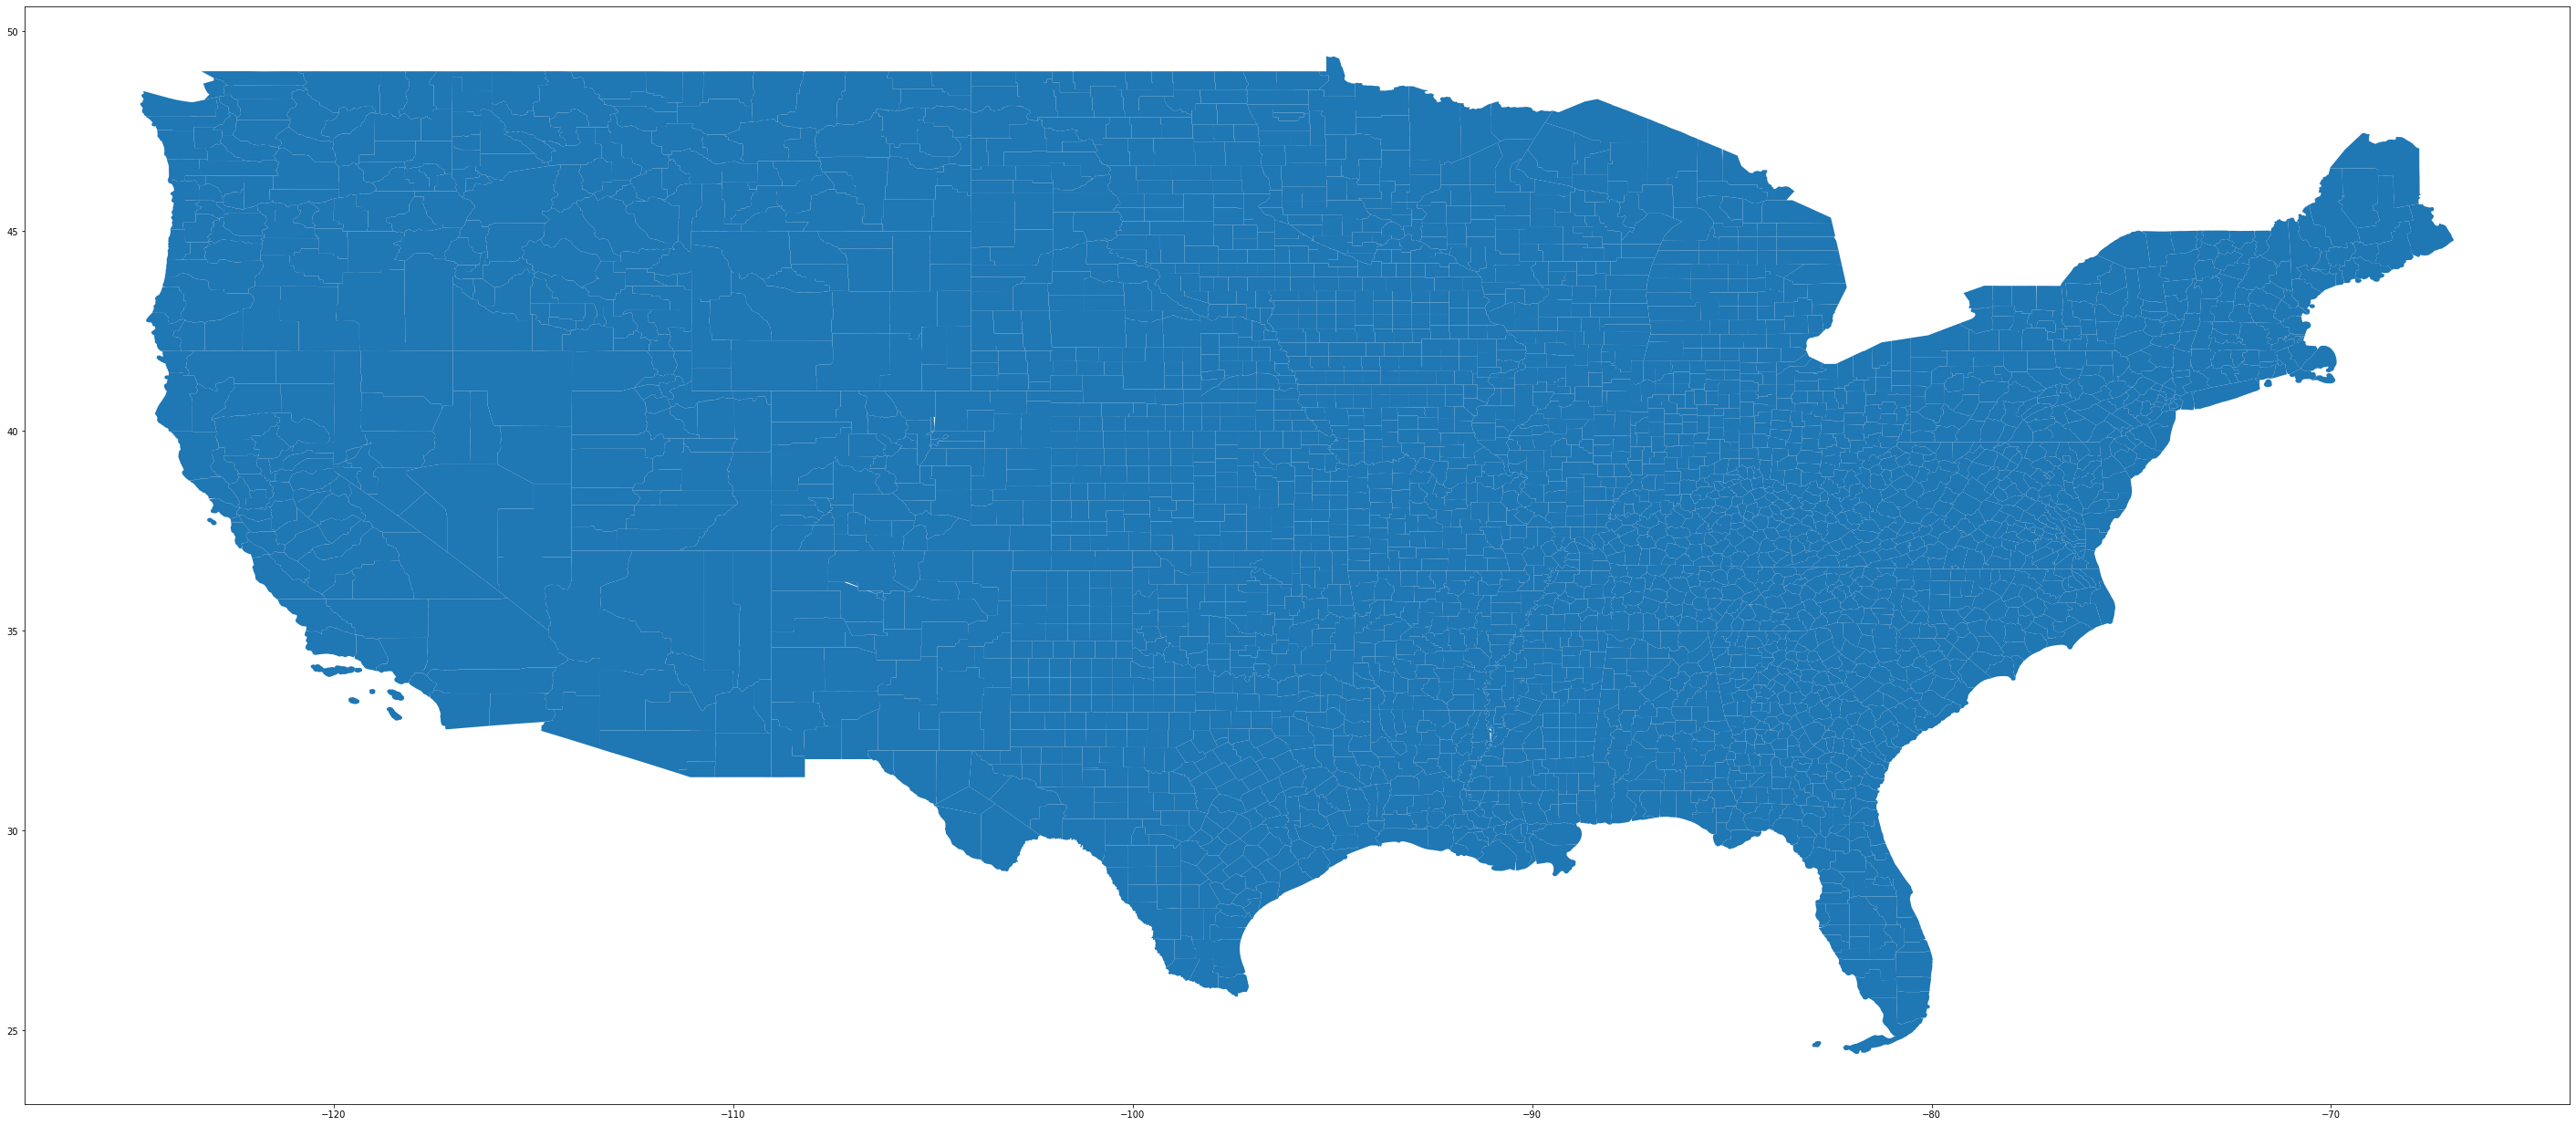

In [242]:
cts.plot(figsize=(50,50))

In [ ]:

from bokeh.sampledata.us_counties import data as counties

from covid_webapp.helpers import *


# Get GeoPandas DF with the regions of each county
def add_county_geometry(df):
    cts = pd.DataFrame(counties).T

    def extract_state(s):
        county, state = s['detailed name'].split(',')
        return state.strip()

    cts['Province_State'] = cts.apply(extract_state, axis=1)

    cts['geometry'] = cts.apply(lambda s: Polygon([(x, y) for x, y in zip(s.lons, s.lats)]), axis=1)
    counties_gpd = gpd.GeoDataFrame(cts, geometry='geometry')

    counties_gpd = counties_gpd.rename(columns={'name': 'County'})
    counties_gpd = counties_gpd.rename(columns={'detailed name': 'County_State'})
    counties_gpd['County_State'] = [f"{c}, {s}" for c, s in
                                    zip(counties_gpd.County.values, counties_gpd.Province_State)]

    # remove territories
    counties_gpd = counties_gpd[~counties_gpd.Province_State.isin(territories)]

    # remove alaska and hawaii to plot them
    counties_gpd = counties_gpd[(counties_gpd.Province_State != "Alaska") & (counties_gpd.Province_State != "Hawaii")]

    # merge the county regions with the dataframe that has the data to plot
    df = counties_gpd[['County_State', 'lats', 'lons']].merge(df.drop(columns='geometry'), on='County_State')

    # remove out-of-state entries
    df = df[(df.Lat != 0) & (df.Long_ != 0)]

    return df

In [281]:
d = get_dataframe('deaths_US')

In [426]:
d['df'].columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'County', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '4/26/21', '4/27/21', '4/28/21', '4/29/21', '4/30/21', '5/1/21',
       'political_affiliation', 'County_State', 'population', 'geometry'],
      dtype='object', length=443)

In [276]:
# GET CSV DATA, CLEAN DATA, AND PLACE INTO DICTIONARY FOR EASY ACCESS
def get_dataframe(dataset, file_path: str = FILE_PATH) -> dict:
    """
    Support function that will retrieve a dictionary which includes a dataset in a dataframe format for simplified downstream sorting and filtering.

    :param dataset: The string name of the dataset for which data is retrieved ('recovered_global', 'deaths_global', 'deaths_US', 'confirmed_global', 'confirmed_US')
    :param file_path: (optional) The root filepath where the applicable data is stored.

    :return: Returns a dictionary with the dataframe along with applicable parameters useful in handling the dataset. The dictionary container the following key-values {'df': <dataframe>, 'attr_cols': <list of names of attribute columns>, 'date_cols_text': <list of date columns in text format>, 'date_cols_dates': <list of date columns in datetime format>}
    """
    file_names = {
        'recovered_global': 'time_series_covid19_recovered_global.csv',
        'deaths_global': 'time_series_covid19_deaths_global.csv',
        'deaths_US': 'time_series_covid19_deaths_US.csv',
        'confirmed_global': 'time_series_covid19_confirmed_global.csv',
        'confirmed_US': 'time_series_covid19_confirmed_US.csv'
    }

    file_name = file_names.get(dataset)

    def get_pol_aff(s):
        return political_affiliations.get(s.Province_State, 'na')

    def make_county_state(s):
        return f"{s.County}, {s.Province_State}"

    f = os.path.join(file_path, file_name)
    if not os.path.isfile(f):
        logging.error(f"{f} is not a file.")

    df = pd.DataFrame()
    if os.path.isfile(f):
        df = pd.read_csv(f)
        if "Province_State" in df.columns:
            # add political affiliation
            df['political_affiliation'] = df.apply(get_pol_aff, axis=1)

            if "Admin2" in df.columns:
                df = df.rename(columns={'Admin2': 'County'})
                df['County_State'] = df.apply(make_county_state, axis=1)

            # format FIPS
            df['FIPS'] = df['UID'].astype(str).apply(lambda x: x[3:])

            # add population by county
            c = Census(os.getenv("CENSUS_API_KEY"), year=2010)
            county_population = pd.DataFrame(
                c.sf1.state_county(['NAME', 'P001001'], state_fips=Census.ALL, county_fips=Census.ALL))
            county_population.rename(
                columns={'P001001': 'population', 'state': 'state_fips', 'county': 'county_fips'}, inplace=True)
            county_population.population = county_population.population.astype(int)
            county_population['FIPS'] = county_population.state_fips + county_population.county_fips
            df = df.merge(county_population[['FIPS', 'population']], on=['FIPS'])

    else:
        if not os.path.isdir(file_path):
            logging.error(f"NOT A PATH: '{file_path}''")
        else:
            logging.error(f"NOT A FILE: '{file_name}''")

    # delete jan and feb
    cols_to_remove = []
    for c in df.columns:
        spl = c.split('/')
        if len(spl) == 3 and spl[2] == '20':
            if spl[0] == '1' or spl[0] == '2':
                cols_to_remove.append(c)
    df.drop(columns=cols_to_remove, inplace=True)

    # remove US territories
    if "Province_State" in df.columns:
        df = df[~df.Province_State.isin(territories)]

    # convert to GeoPandas if there are lat and lon coordinates
    if "Lat" in df.columns and "Long_" in df.columns:
        df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Long_, df.Lat))

    attr_cols, date_cols_text, date_cols_dates = get_column_groups(df)

    return {'df': df, 'attr_cols': attr_cols, 'date_cols_text': date_cols_text, 'date_cols_dates': date_cols_dates}

def get_column_groups(df):
    """
    Returns a tuple of 3 lists that include the columns of a dataframe split into 3 groups. 'Attribute Columns' are non-date columns in a dataframe,  'Date Columns Text' are date columns in text format and 'Date Columns Date' are date columns in datetime format.

    :param df:  The dataframe that will be evaluated and for which the column groups are returned.

    :return: A tuple of 3 lists: the attribute columns (all columns that are not dates), date columns in text format and the date columns is datetime format.
    """
    date_cols_dates = pd.to_datetime(df.columns, errors='coerce')
    date_cols_tf = [not pd.isnull(c) for c in date_cols_dates]
    date_cols_dates = date_cols_dates[date_cols_tf]
    date_cols_text = df.columns[date_cols_tf]
    attr_cols = df.columns[[not c for c in date_cols_tf]]

    return attr_cols, date_cols_text, date_cols_dates


# SUPPORT FUNCTIONS
# group by state
def get_df_by_state(_df) -> pd.DataFrame:
    """
    Support function that will return a dataframe grouped by 'Province State' where values are summed.

    :param _df:  The dataframe that will be grouped.

    :return: The grouped dataframe
    """
    return _df.groupby(by='Province_State').sum().reset_index()


# group by county in a state
def get_df_by_counties(_df, state) -> pd.DataFrame:
    """
    A support function that will return the entries in a provided dataframe that match the provided state.  The state value provided is not case sensitive.

    :param _df:  The initial dataframe that will be filtered.
    :param state: The state string name that will be used to filter the dataframe.

    :return: A dataframe that includes the entries of the provided dataframe that only include the provided state.
    """
    return _df[_df.Province_State.str.lower() == state.lower()]


def get_rankings(_df, top_n=None) -> list:
    """
    Support function that will return a list of the top n listings in a dataframe based on the most recent date.  Results are listing in descending order.  If no top_n value is provided, all items in the dataframe are sorted.

    :param _df:  The dataframe that will be filtered and sorted.
    :param top_n: (optional) An integer value that will restrict the returned list to the top n number of listings.

    :return: A list of top_n indexes from a dataframe
    """
    attr_cols, date_cols_text, date_cols_dates = get_column_groups(_df)
    a_cols = [c for c in _df.columns if c in attr_cols]

    rv_df = _df[date_cols_text].rank(ascending=False)
    rv_df = pd.concat([_df.loc[rv_df.index][a_cols], rv_df], axis=1)

    if top_n is not None:
        return rv_df.nsmallest(top_n, date_cols_text[-1]).sort_values(by=date_cols_text[-1], ascending=True)

    return rv_df.sort_values(by=date_cols_text[-1])


# get data per day
def get_by_day(_df):
    """
    Return a dataframe that contains cumulative values in date columns in a daily value format.

    :param _df:  A dataframe where the values in each date column are cumulative values.

    :return: The supplied dataframe with daily data instead of cumulative data.
    """
    _, date_cols_text, _ = get_column_groups(_df)
    daily = _df[date_cols_text] - _df[date_cols_text].shift(axis=1)
    attr_cols = set(_df.columns) - set(date_cols_text)
    daily = pd.concat([_df[attr_cols], daily], axis=1)

    return daily


def get_daily_growth_rate(_df):
    """
    Return a dataframe that includes values that represent the change rate vs the prior day for all values in date columns.

    :param _df:  A dataframe of cumulative values in date columns

    :return: A dataframe with the same columns and rows as the original dataframe, except the values are daily change rates rather than cumulative absolute values.
    """
    _, date_cols_text, _ = get_column_groups(_df)
    _df = get_by_day(_df)
    daily_rate = _df[date_cols_text] / _df[date_cols_text].shift(axis=1)
    attr_cols = set(_df.columns) - set(date_cols_text)
    daily_rate = pd.concat([_df[attr_cols], daily_rate], axis=1)
    daily_rate = daily_rate.fillna(1)
    return daily_rate




In [277]:
from bokeh.embed import json_item
from bokeh.plotting import figure
from bokeh.models import FactorRange, ColumnDataSource, HoverTool, NumeralTickFormatter
from bokeh.models.callbacks import CustomJS

from django.http import JsonResponse

# from .helpers import *


def _get_plot_data(data_type, frequency, state, county):
    # set dataframes
    if data_type == 'infections':
        df_dict = get_dataframe('confirmed_US')
    else:
        df_dict = get_dataframe('deaths_US')

    # _, date_cols_text, date_cols_dates = get_column_groups(df)

    df = df_dict['df']
    date_cols_text = df_dict['date_cols_text']
    date_cols_dates = df_dict['date_cols_dates']

    if frequency == 'daily':
        all_data = get_by_day(df)
    else:
        all_data = df.copy()

    if state == 'United States':
        plot_data = all_data.sum()[date_cols_text].values
    else:
        if county == 'All':
            plot_data = all_data[all_data.Province_State == state].sum()[date_cols_text].values
        else:
            plot_data = all_data[(all_data.Province_State == state) & (all_data.County == county)].sum()[
                date_cols_text].values

    # setup x axis groupings
    factors = [(str(c.year), c.month_name(), str(c.day)) for c in date_cols_dates]

    return plot_data, factors


def plot_state_chart(request, state="United States", county='All', frequency='daily', data_type='infections', rolling_window=14):
    """
    Plots the values for a selected state, county or the entire United States.

    :param request:  The HTML request that should include values for 'state', 'county', 'frequency', 'data_type' and 'rolling_window'.  See the parameter descriptions below for contraints and defaults for each parameter.
    :param state: (optional) Default 'Massachusetts'.  The name of the state to plot.
    :param county: (optional) Default 'All'.  The county to plot or 'All' counties of a state of value is 'All'.
    :param frequency: (optional) Default 'daily'.  Whether to plot daily or cumulative values.
    :param data_type: (optional) Default 'infections'.  Plot 'infections' data or 'deaths' data.
    :param rolling_window: (optional) Default 14.  The number of days to use when drawing the daily average line in the plot.

    :return: A Bokeh JSON formatted plot that can be handled by JavaScript for HTML presentation.
    """
    if request is not None:
        state = request.GET.get('state', 'United States')
        county = request.GET.get('county', 'All')
        frequency = request.GET.get('frequency', 'daily')
        data_type = request.GET.get('data_type', 'infections').lower()
        rolling_window = int(request.GET.get('rolling_window', 14))

    state = ' '.join([word.capitalize() for word in state.split(' ')])
    county = county.capitalize()

    plot_data, factors = _get_plot_data(data_type, frequency, state, county)

    # # setup x axis groupings
    # factors = [(c.month_name(), str(c.day)) for c in DATE_COLS_DATES]

    # setup Hover tool
    hover = HoverTool()
    hover.tooltips = [
        ("Date", "@date"),
        (data_type.capitalize(), "@val{0,0}"),
        (f"{rolling_window}-day Avg", "@rolling_avg{0,0.0}")
    ]

    # setup figure
    p = figure(x_range=FactorRange(*factors), sizing_mode='stretch_both',  # plot_height=500, plot_width=900,
               y_axis_type='linear', y_axis_label=data_type, output_backend="webgl",
               toolbar_location=None, tools=[hover],
               title=f"{state} New {data_type.capitalize()}{' by Day' if frequency == 'daily' else ''}")
    p.title.text_font_size = '12pt'
    p.yaxis.formatter = NumeralTickFormatter(format="0,000")

    source = ColumnDataSource(
        data=dict(date=factors, val=plot_data, rolling_avg=pd.Series(plot_data).rolling(rolling_window).mean().values))

    b = p.vbar(x='date', top='val', source=source, color='red', width=.5)

    if frequency == 'daily':
        l = p.line(x='date', y='rolling_avg', source=source, color='black', width=3, legend_label=f"{rolling_window}-Day Rolling Average")
        p.legend.location = 'top_left'

    p.xaxis.major_label_orientation = 1
    p.xaxis.group_text_font_size = "10pt"  # months size
    p.xaxis.major_label_text_font_size = "6pt"  # date size
    p.yaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    callback = CustomJS(args=dict(source=source), code="""

        // JavaScript code goes here

        var updated_data; 

        // the model that triggered the callback is cb_obj:
        fetch(cb_obj.value)
        .then( response = return response.json() )
        .then( x => udpated_data = x ) 

        // models passed as args are automagically available
        source.data = updated_data;

        """)
    
    return p
#     return JsonResponse(json_item(p))

In [278]:
from bokeh.plotting import show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [279]:
_p = plot_state_chart(None)

In [280]:
show(_p)

In [25]:
plot_data, factors = _get_plot_data('infections', "daily", "United States", "All")

In [28]:
len(plot_data)

413

In [32]:
factors

[('March', '1', '2020'),
 ('March', '2', '2020'),
 ('March', '3', '2020'),
 ('March', '4', '2020'),
 ('March', '5', '2020'),
 ('March', '6', '2020'),
 ('March', '7', '2020'),
 ('March', '8', '2020'),
 ('March', '9', '2020'),
 ('March', '10', '2020'),
 ('March', '11', '2020'),
 ('March', '12', '2020'),
 ('March', '13', '2020'),
 ('March', '14', '2020'),
 ('March', '15', '2020'),
 ('March', '16', '2020'),
 ('March', '17', '2020'),
 ('March', '18', '2020'),
 ('March', '19', '2020'),
 ('March', '20', '2020'),
 ('March', '21', '2020'),
 ('March', '22', '2020'),
 ('March', '23', '2020'),
 ('March', '24', '2020'),
 ('March', '25', '2020'),
 ('March', '26', '2020'),
 ('March', '27', '2020'),
 ('March', '28', '2020'),
 ('March', '29', '2020'),
 ('March', '30', '2020'),
 ('March', '31', '2020'),
 ('April', '1', '2020'),
 ('April', '2', '2020'),
 ('April', '3', '2020'),
 ('April', '4', '2020'),
 ('April', '5', '2020'),
 ('April', '6', '2020'),
 ('April', '7', '2020'),
 ('April', '8', '2020'),
 ('